# Environments

# Eval

In [1]:
"""
In this demo, we evaluate the performance of the
lofi bandit on a tabular dataset
"""
import jax
import pickle
import numpy as np
import pandas as pd
import flax.linen as nn
from datetime import datetime
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from bandits import training as btrain
from bandits.agents.linear_bandit import LinearBandit
from bandits.agents.low_rank_filter_bandit import LowRankFilterBandit
from bandits.agents.neural_linear import NeuralLinearBandit

from bandits.environments.mnist_env import MnistEnvironment

import lofi_tabular as experiment

In [4]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
class MLP(nn.Module):
    num_arms: int

    @nn.compact
    def __call__(self, x):
        # x = nn.Dense(50)(x)
        # x = nn.relu(x)
        x = nn.Dense(500, name="last_layer")(x)
        x = nn.relu(x)
        x = nn.Dense(self.num_arms)(x)
        return x

In [6]:
ntrials = 1
npulls = 20
key = jax.random.PRNGKey(314)
key_env, key_train, key_eval = jax.random.split(key, 3)

# env = TabularEnvironment(key_env, ntrain=ntrain, name='statlog', intercept=False, path="../bandit-data")
env = MnistEnvironment(key, ntrain=500)
env_test = MnistEnvironment(key, ntrain=8000)

num_arms = env.labels_onehot.shape[-1]
model = MLP(num_arms)

In [7]:
optimisers = {}
results = {}

## LoFi: Fixed dynamics

In [9]:
name_agent = "lofi-fixed"
extra_params = {
    "memory_size": 10,
    "model": model,
    "dynamics_weights": 1.0,
    "dynamics_covariance": 0.0,

}

@jax.jit
def bbf(**heval):
    res = experiment.warmup_and_run(
        heval, 
        experiment.transform_hparams_lofi_fixed,
        LowRankFilterBandit,
        env,
        key_train,
        npulls,
        **extra_params,
    )

    
    return res["hist_train"]["rewards"].sum()

In [10]:
%%time
# try q=0, γ=1
pbounds = {
    "log_em_cov": [-15, -1],
    "log_init_cov": [-15, -1],
}


optimiser = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=2718,
)

optimiser.maximize(init_points=5, n_iter=15)

|   iter    |  target   | log_em... | log_in... |
-------------------------------------------------
| 1         | 164.0     | -9.033    | -5.159    |
| 2         | 80.0      | -3.12     | -14.94    |
| 3         | 228.0     | -13.82    | -14.9     |
| 4         | 193.0     | -7.946    | -8.266    |
| 5         | 53.0      | -2.74     | -2.798    |
| 6         | 193.0     | -13.0     | -10.62    |
| 7         | 167.0     | -10.26    | -14.97    |
| 8         | 45.0      | -15.0     | -1.0      |
| 9         | 211.0     | -15.0     | -12.99    |
| 10        | 214.0     | -14.92    | -14.84    |
| 11        | 46.0      | -14.97    | -7.96     |
| 12        | 199.0     | -10.08    | -11.32    |
| 13        | 216.0     | -12.59    | -13.04    |
| 14        | 85.0      | -1.0      | -9.249    |
| 15        | 230.0     | -10.27    | -8.674    |
| 16        | 198.0     | -9.623    | -9.444    |
| 17        | 223.0     | -10.9     | -7.0      |
| 18        | 50.0      | -8.501    | -1.0      |


In [11]:
%%time
res = experiment.warmup_and_run(
    optimiser.max["params"], 
    experiment.transform_hparams_lofi_fixed,
    LowRankFilterBandit,
    env_test,
    key_eval,
    npulls,
    n_trials=8,
    **extra_params,
)

res = jax.tree_map(np.array, res)
results[name_agent] = res
optimisers[name_agent] = optimiser

CPU times: user 28.1 s, sys: 910 ms, total: 29 s
Wall time: 41 s


## Linear

In [12]:
name_agent = "linear"

@jax.jit
def bbf(**heval):
    res = experiment.warmup_and_run(
        heval, 
        experiment.transform_hparams_linear,
        LinearBandit,
        env,
        key_train,
        npulls,
    )

    
    return res["hist_train"]["rewards"].sum()

In [13]:
%%time
pbounds = {
    "eta": [0, 10],
    "log_lambda": [-8, 0],
}

optimiser = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=2718,
)

optimiser.maximize(init_points=5, n_iter=15)

|   iter    |  target   |    eta    | log_la... |
-------------------------------------------------
| 1         | 48.0      | 4.262     | -2.377    |
| 2         | 45.0      | 8.486     | -7.964    |
| 3         | 45.0      | 0.8413    | -7.942    |
| 4         | 40.0      | 5.039     | -4.152    |
| 5         | 52.0      | 8.757     | -1.028    |
| 6         | 45.0      | 3.228     | -6.277    |
| 7         | 57.0      | 5.14      | -0.7948   |
| 8         | 64.0      | 6.432     | 0.0       |
| 9         | 92.0      | 0.7073    | 0.0       |
| 10        | 191.0     | 0.005823  | -1.728    |
| 11        | 44.0      | 0.0       | -2.84     |
| 12        | 190.0     | 0.001661  | -1.662    |
| 13        | 60.0      | 0.4888    | -1.671    |
| 14        | 43.0      | 5.762     | -4.201    |
| 15        | 193.0     | 0.005683  | -1.998    |
| 16        | 196.0     | 0.001958  | -1.133    |
| 17        | 182.0     | 0.02616   | -0.6817   |
| 18        | 43.0      | 10.0      | -4.53     |


In [14]:
%%time
res = experiment.warmup_and_run(
    optimiser.max["params"], 
    experiment.transform_hparams_linear,
    LinearBandit,
    env_test,
    key_eval,
    npulls,
    n_trials=8,
)

results[name_agent] = res
optimisers[name_agent] = optimiser

CPU times: user 51.5 s, sys: 4.43 s, total: 56 s
Wall time: 10.5 s


## Neural linear

In [15]:
name_agent = "neural-linear"
extra_params = {
    "model": model,

}

@jax.jit
def bbf(**heval):
    res = experiment.warmup_and_run(
        heval, 
        experiment.transform_hparams_neural_linear,
        NeuralLinearBandit,
        env,
        key_train,
        npulls,
        **extra_params
    )
    
    return res["hist_train"]["rewards"].sum()

In [16]:
%%time
pbounds = {
    "eta": [0, 10],
    "log_lambda": [-8, 0],
    "log_lr": [-10, -2]
}


optimiser = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=2718,
)

optimiser.maximize(init_points=5, n_iter=15)

|   iter    |  target   |    eta    | log_la... |  log_lr   |
-------------------------------------------------------------
| 1         | 45.0      | 4.262     | -2.377    | -3.211    |
| 2         | 53.0      | 0.04448   | -7.327    | -9.942    |
| 3         | 45.0      | 5.039     | -4.152    | -2.994    |
| 4         | 45.0      | 8.715     | -0.2811   | -2.535    |
| 5         | 45.0      | 0.375     | -6.947    | -4.983    |
| 6         | 40.0      | 2.44      | -8.0      | -10.0     |
| 7         | 45.0      | 5.03      | -4.264    | -4.832    |
| 8         | 57.0      | 9.86      | -1.025    | -7.315    |
| 9         | 49.0      | 9.911     | -1.267    | -7.7      |
| 10        | 46.0      | 9.907     | -0.8264   | -7.41     |
| 11        | 54.0      | 7.318     | -1.496    | -7.878    |
| 12        | 45.0      | 8.662     | -6.697    | -4.953    |
| 13        | 43.0      | 0.3076    | -2.579    | -5.038    |
| 14        | 45.0      | 3.857     | -6.982    | -6.741    |
| 15    

In [17]:
%%time
res = experiment.warmup_and_run(
    optimiser.max["params"], 
    experiment.transform_hparams_neural_linear,
    NeuralLinearBandit,
    env_test,
    key_eval,
    npulls,
    n_trials=8,
    **extra_params
)

results[name_agent] = res
optimisers[name_agent] = optimiser

CPU times: user 28.8 s, sys: 2.22 s, total: 31 s
Wall time: 9.06 s


## Neural Greedy (replay-buffer)

In [18]:
import optax
from bandits.agents.neural_greedy import NeuralGreedyBandit

In [19]:
name_agent = "rsgd"
extra_params = {
    "model": model,
    "memory_size": 10,
    "epsilon": 0.1,
    "n_inner": 1.0,

}

@jax.jit
def bbf(**heval):
    res = experiment.warmup_and_run(
        heval, 
        experiment.transform_hparams_rsgd,
        NeuralGreedyBandit,
        env,
        key_train,
        npulls,
        **extra_params
    )
    
    return res["hist_train"]["rewards"].sum()

In [20]:
%%time
pbounds = {
    "log_lr": [-10, -2]
}


optimiser = BayesianOptimization(
    f=bbf,
    pbounds=pbounds,
    random_state=2718,
)

optimiser.maximize(init_points=5, n_iter=15)

|   iter    |  target   |  log_lr   |
-------------------------------------
| 1         | 147.0     | -6.59     |
| 2         | 79.0      | -4.377    |
| 3         | 65.0      | -3.211    |
| 4         | 195.0     | -9.964    |
| 5         | 195.0     | -9.327    |
| 6         | 214.0     | -8.678    |
| 7         | 183.0     | -7.882    |
| 8         | 209.0     | -8.44     |
| 9         | 184.0     | -8.822    |
| 10        | 95.0      | -4.826    |
| 11        | 195.0     | -9.327    |
| 12        | 61.0      | -2.0      |
| 13        | 170.0     | -7.3      |
| 14        | 130.0     | -5.789    |
| 15        | 190.0     | -9.644    |
| 16        | 181.0     | -7.602    |
| 17        | 205.0     | -8.568    |
| 18        | 183.0     | -8.183    |
| 19        | 109.0     | -5.336    |
| 20        | 146.0     | -6.96     |
CPU times: user 1min 25s, sys: 1min 35s, total: 3min
Wall time: 58.1 s


In [21]:
%%time
res = experiment.warmup_and_run(
    optimiser.max["params"], 
    experiment.transform_hparams_rsgd,
    NeuralGreedyBandit,
    env_test,
    key_eval,
    npulls,
    n_trials=8,
    **extra_params
)

results[name_agent] = res
optimisers[name_agent] = optimiser

CPU times: user 3 s, sys: 183 ms, total: 3.18 s
Wall time: 2.5 s


## Plots

In [24]:
results.keys()

dict_keys(['lofi-fixed', 'linear', 'neural-linear', 'rsgd'])

In [31]:
name_mapping = {
    "lofi-fixed": "Neural-Lofi TS",
    "linear": "Linear TS",
    "neural-linear": "Neural-linear TS",
    "rsgd": "Neural-RB Greedy",
}

In [40]:
filename = "bandit-showdown-mem10.pkl"
path = os.path.join("output", "results", filename)

with open(path, "wb") as f:
    pickle.dump(results, f)

lofi-fixed - 6245.50±291.78
linear - 5102.75±61.36
neural-linear - 3508.50±322.13
rsgd - 5780.12±37.38


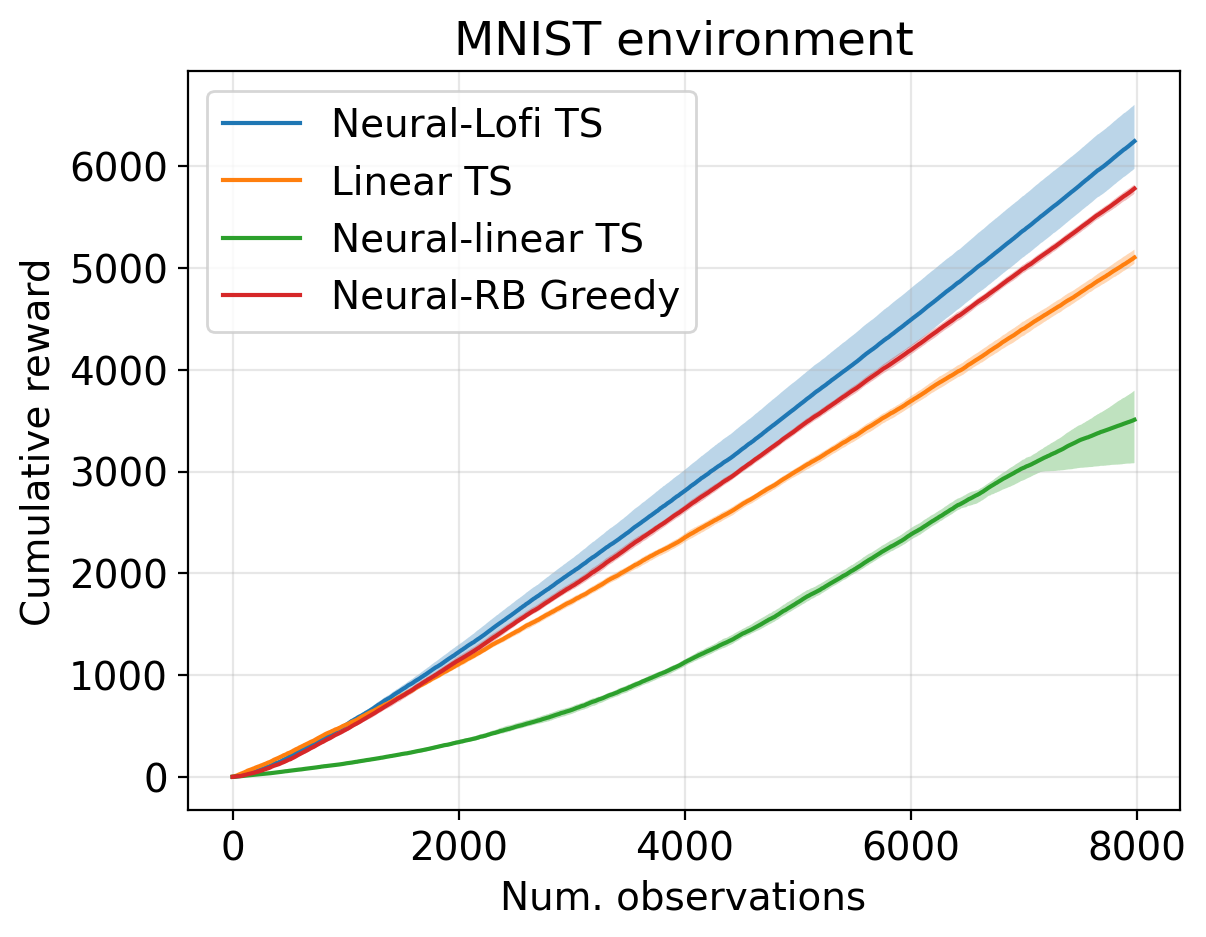

In [33]:
for name, res in results.items():
    label = name_mapping[name]
    rewards = res["hist_train"]["rewards"]
    mean_reward = rewards.sum(axis=1).mean()
    std_reward = rewards.sum(axis=1).std()

    rewards = pd.DataFrame(rewards).T.cumsum(axis=0)
    print(f"{name} - {mean_reward:0.2f}±{std_reward:0.2f}")

    nsteps = len(rewards)
    rmean = rewards.mean(axis=1)
    ubound = rewards.quantile(0.9, axis=1)
    lbound = rewards.quantile(0.1, axis=1)
    
    plt.fill_between(rewards.index, lbound, ubound, alpha=0.3)
    plt.plot(rewards.index, rmean, label=label)
    
# plt.plot([0, nsteps], [0, nsteps], c="tab:gray", linewidth=1, linestyle="--", label="oracle")
plt.legend()
plt.grid(alpha=0.3)
plt.ylabel("Cumulative reward")
plt.xlabel("Num. observations")
plt.title("MNIST environment")
plt.savefig("./output/figures/mnist-bandits-memory10.pdf")